In [ ]:
cd /content/drive/MyDrive/AAIC course/Case Study 1/Data

/content/drive/MyDrive/AAIC course/Case Study 1/Data


## Libraries

In [ ]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 76.1 MB 53 kB/s 
     |████████████████████████████████| 308 kB 7.1 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 210 kB 16.3 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 113 kB 17.9 MB/s 
     |████████████████████████████████| 149 kB 19.8 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=21f0081f724e25e8ecd5534dbf1e1a22d6474e2d74364ab10702f33ef3384c58
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# reading data
import pandas as pd
import numpy as np

# visualization library
!pip install plotly --upgrade
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.express as px

# Preprocessing
import joblib
from geopy import distance # to find distance between long and lat
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# utility libraries
import time
from tqdm import tqdm 
from tqdm import tqdm
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# to check performance of models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

# Cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# DL
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

# Hyperparameter tunning
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV 

In [ ]:
train = pd.read_feather('train_df_V1.0.feather')
train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,customer_geolocation_lat,customer_geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,9350,maua,SP,-23.680729,-46.444238,-23.576983,-46.587161
1,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,1,credit_card,2,223.38,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,bed_bath_table,5,13405,piracicaba,SP,-22.708702,-47.664701,-23.576983,-46.587161
2,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,1,credit_card,1,44.11,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,2017-09-11 11:43:25,35.39,8.72,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,baby,5,7025,guarulhos,SP,-23.482841,-46.543454,-23.576983,-46.587161
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,9350,maua,SP,-23.680729,-46.444238,-23.564630,-46.534268
4,9e9f909cd250058d062bb2b0b0161c92,e15a69da6ddca9fc7bf178c28f529529,delivered,2017-07-02 15:37:04,2017-07-04 04:30:13,2017-07-04 10:09:49,2017-07-13 17:36:01,2017-08-01,1,boleto,1,153.69,55fd57195ae0bd2ecf368bbc4be6ad96,3366,sao paulo,SP,1,60c031bf1162848b7ee14f56f432285b,2a5b78b41cd05baeac8df54c6606b92c,2017-07-10 04:30:13,137.97,15.72,55.0,706.0,2.0,225.0,18.0,11.0,13.0,health_beauty,5,35570,formiga,MG,-20.462536,-45.433059,-23.564630,-46.534268


In [ ]:
train.dropna(inplace=True)
train.reset_index(drop=True,inplace=True)

In [ ]:
# feature that we are dropping
drop_feat = ['order_id', 'customer_id', 'order_purchase_timestamp','order_approved_at', \
                 'order_delivered_carrier_date','order_delivered_customer_date', \
                 'order_estimated_delivery_date','customer_unique_id', 'customer_zip_code_prefix', \
                 'customer_city','customer_state', 'order_item_id', 'product_id', 'seller_id',\
                 'shipping_limit_date', 'seller_zip_code_prefix', 'seller_city', 'seller_state',\
                 'seller_geolocation_lat', 'seller_geolocation_lng','customer_geolocation_lat', \
                 'customer_geolocation_lng','order_status']

# features we need to standardize
std_feat = ['payment_value', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'distance', 'purchase_time', 'difference_in_delivery',
       'order_fre_ratio', 'estimate_day', 'actual_delivery', 'frequency',
       'recency', 'monetary', 'age']

In [ ]:
# reading seller data
seller_data = pd.read_feather('sellers_dataV2.0.feather')

# readin standard scaler file
std_scale = joblib.load('std_scaler_of_train_dataV1.0.bin')

def Update_feat(input_df, seller_data):
    """
    Return 
    ----------------
    The dataframe with all preprocessing ready to train or predict for model  
    """
    # calculate distance
    input_df['distance'] = 0.0
    for id, row in input_df.iterrows():
        cust_ll = tuple(row[['customer_geolocation_lat', 'customer_geolocation_lng']].values)
        seller_ll = tuple(row[['seller_geolocation_lat', 'seller_geolocation_lng']].values)
        dist = distance.distance(cust_ll, seller_ll).km
        input_df.at[id,'distance'] = np.round(dist,3)

    # taking hour from timestamp
    input_df["purchase_time"] = input_df.order_purchase_timestamp.dt.hour
    # taking month from timestamp
    input_df['purchase_month'] = input_df.order_purchase_timestamp.dt.month
    # taking week and weedays from timestamp
    input_df['purchase_weekday'] = input_df.order_purchase_timestamp.dt.weekday
    input_df['purchase_week'] = input_df.order_purchase_timestamp.dt.week

    # to find delivery is late or not
    # estimate - deliver date
    input_df['difference_in_delivery'] = (input_df.order_estimated_delivery_date - input_df.order_delivered_customer_date).dt.days

    def is_late(x):
        if x >= 0:
            # Early
            return 1
        else:
            # late
            return 0
    # Is it late
    input_df['late'] = 0
    input_df.late = input_df.difference_in_delivery.apply(lambda x: is_late(x))
    # order to freight ratio
    # add 1 to avoid divide by 0
    input_df['order_fre_ratio'] = input_df.price / (input_df.freight_value + 1)

    # estimate days in delivery
    input_df['estimate_day'] = (input_df.order_estimated_delivery_date - input_df.order_purchase_timestamp).dt.days

    # actual day to delivery
    input_df['actual_delivery'] = (input_df.order_delivered_customer_date - input_df.order_purchase_timestamp).dt.days

    # target variable
    # creating dictionary to changing the values of column
    review_dic = {5:1, 4:1, 3:0, 2:0, 1:0}
    # if satisfy 1 else 0
    # map dictionary
    input_df['review_score'] = input_df['review_score'].map(review_dic)

    # one hot encoding of columns payment_type
    coun_vect_pay = CountVectorizer(lowercase=False)
    # to use vocab while deploying
    coun_vect_pay.vocabulary_ = {'boleto': 0, 'credit_card': 1, 'debit_card': 2, 'voucher': 3}
    count_matrix = coun_vect_pay.transform(input_df.payment_type)
    # Converting sparse matrix to array of array
    count_array = count_matrix.toarray()
    # array to dataframe
    one_hot_pay = pd.DataFrame(data=count_array,columns = coun_vect_pay.get_feature_names())
    # Join the encoded input_df
    input_df = input_df.join(one_hot_pay)
    # Drop column payment_type because it is encoded
    input_df = input_df.drop('payment_type', axis=1)

    # we taking only those category who particiapation is in top 20
    # take other categories as other
    prod_eng_ind = ['bed_bath_table', 'health_beauty', 'sports_leisure',
        'computers_accessories', 'furniture_decor', 'housewares',
        'watches_gifts', 'telephony', 'auto', 'toys', 'garden_tools',
        'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
        'fashion_bags_accessories', 'pet_shop', 'consoles_games',
        'office_furniture']
    def cat_val(valu):
        if valu in set(prod_eng_ind):
            return valu
        else:
            return 'other'
    # create new column and map the names
    input_df['cat_english'] = input_df['product_category_name_english']
    input_df['cat_english'] = input_df['cat_english'].apply(lambda x:cat_val(x))

    # one hot encoding of columns category name
    coun_vect_cat = CountVectorizer(lowercase=False)

    # to use vocab while deploying
    coun_vect_cat.vocabulary_ = {'auto': 0, 'baby': 1, 'bed_bath_table': 2, 'computers_accessories': 3, 'consoles_games': 4,\
                                'cool_stuff': 5, 'electronics': 6, 'fashion_bags_accessories': 7, 'furniture_decor': 8, 'garden_tools': 9,\
                                'health_beauty': 10, 'housewares': 11, 'office_furniture': 12, 'other': 13, 'perfumery': 14, 'pet_shop': 15,\
                                'sports_leisure': 16, 'stationery': 17, 'telephony': 18, 'toys': 19, 'watches_gifts': 20}

    count_matrix = coun_vect_cat.transform(input_df.cat_english)
    # Converting sparse matrix to array of array
    count_array = count_matrix.toarray()
    # array to dataframe
    one_hot_cat = pd.DataFrame(data=count_array,columns = coun_vect_cat.get_feature_names())
    # Join the encoded input_df
    input_df = input_df.join(one_hot_cat)
    # Drop column category name because it is encoded
    input_df = input_df.drop(['product_category_name_english','cat_english'], axis=1)

    # Create dictionary of 25 percentile of seller data for those seller who are new to input_df data
    outside_seller = {'frequency':2.0000, 'recency':13.0000, 'monetary':175.7750, 'RFM_Score':2.6975, 'age':123.0000}
    # taking unique seller ids
    input_df_sellers = list(input_df.seller_id.value_counts().index)
    sell_id = list(seller_data.seller_id.value_counts().index)
    # iterate over input_df seller id
    for idd in input_df_sellers:
        # iterate over seller id from seller data if present then do nothing
        if idd in set(sell_id):
            pass
        else:
            # if id is new then we append new id inplace of missing id 
            # and assign 25 percentile values of dataframe
            outside_seller['seller_id'] = idd
            seller_data = seller_data.append(outside_seller, ignore_index=True)
    
    # joining seller data
    input_df = input_df.merge(seller_data, on='seller_id')

    # standard scaler
    input_df.loc[:,std_feat] = std_scale.transform(input_df.loc[:,std_feat])

    # dropping unnecessary features
    input_df.drop(columns=drop_feat,inplace=True)
    return input_df

In [ ]:
# preprocess data
train_df = Update_feat(train, seller_data)

In [ ]:
train_df

,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,distance,purchase_time,purchase_month,purchase_weekday,purchase_week,difference_in_delivery,late,order_fre_ratio,estimate_day,actual_delivery,boleto,credit_card,debit_card,voucher,auto,baby,bed_bath_table,computers_accessories,consoles_games,cool_stuff,electronics,fashion_bags_accessories,furniture_decor,garden_tools,health_beauty,housewares,office_furniture,other,perfumery,pet_shop,sports_leisure,stationery,telephony,toys,watches_gifts,frequency,recency,monetary,RFM_Score,age
0,1,1,-0.690273,-0.547143,-0.766443,-0.886801,-0.803067,1.011380,-0.431840,-0.689163,-0.637847,-0.857164,4,-0.982141,-0.895490,10,0,40,-0.389387,1,-0.349738,-0.953882,-0.426496,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.638662,3.119737,-0.684833,7.62,-0.185287
1,1,3,-0.588694,-0.547143,-0.831312,-0.886801,-0.803067,1.011380,-0.431840,-0.689163,-0.637847,-0.857164,4,-0.986823,0.605768,8,1,33,-0.191090,1,-0.313583,-1.296552,-1.062755,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.638662,3.119737,-0.684833,7.62,-0.185287
2,1,1,-0.588694,-0.547143,-0.831312,-0.886801,-0.803067,1.011380,-0.431840,-0.689163,-0.637847,-0.857164,5,-0.974122,0.605768,8,2,31,-0.389387,1,-0.313583,-1.296552,-0.744625,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.638662,3.119737,-0.684833,7.62,-0.185287
3,1,1,-0.556023,-0.547143,-0.395172,-0.886801,-0.803067,1.011380,-0.431840,-0.689163,-0.637847,-0.857164,3,-0.211827,1.544053,10,0,43,-0.587684,1,-0.470060,-0.382764,0.209763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.638662,3.119737,-0.684833,7.62,-0.185287
4,1,1,-0.125097,-0.444722,3.303735,1.015521,-0.924580,0.435949,-0.354300,-0.876885,-0.025601,-0.857164,1,-0.972187,-0.707832,8,3,34,0.502951,1,-0.612883,-0.382764,-0.850668,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.638662,3.119737,-0.684833,7.62,-0.185287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89293,1,1,-0.226936,-0.684475,-0.395172,-2.488757,-0.695397,-0.139482,-0.234466,-0.626590,0.280523,-0.256009,1,0.436126,-0.707832,10,3,43,0.304653,1,-0.633443,0.416801,0.103720,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.754400,3.253677,-0.744111,1.03,-0.869028
89294,1,6,0.176953,0.138177,1.627495,-3.289734,2.951548,1.011380,0.188477,-0.751737,0.586646,-0.599526,5,1.958976,-0.332518,7,6,26,-0.488535,1,-0.336311,0.759472,1.270194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.754400,4.666127,-0.740494,0.94,-0.167135
89295,1,1,-0.052880,0.061590,-0.573217,-1.287290,0.535120,-0.714913,-0.460036,-0.376294,-0.561317,-0.599526,5,-0.860861,1.168739,3,1,13,0.205505,1,0.448179,-0.496987,-0.744625,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.754400,5.822875,-0.740831,0.88,0.407692
89296,2,1,0.508418,1.432473,-0.062547,0.414787,-0.855364,-0.139482,-0.511635,-0.251147,-0.408255,0.259267,5,1.521382,-0.520175,12,2,51,0.403802,1,1.262608,1.216366,0.739978,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.754400,2.583981,-0.734803,1.11,-1.201823


In [ ]:
# seperate dependent and independent features
X = train_df.drop('review_score',axis=1)
y = train_df.review_score

In [ ]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
def performace_of_model(model, y_train, X_train, y_test,X_test):
    """
    Return 
    ----------------
    The performance of model  
    """
    # to check the performance of model
    # predict using model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # printing f1 scores
    print('F1 Score on Train data ',f1_score(y_train, y_train_pred))
    print('F1 Score on Test data ',f1_score(y_test,y_test_pred))

    # printing matthew coef for train and test
    print('/n Matthews coef on Train data is ',matthews_corrcoef(y_train, y_train_pred))
    print('Matthews coef on Test data is ',matthews_corrcoef(y_test,y_test_pred))

    # printing classification report
    target_names = ['class 0', 'class 1']
    print('Classification report for train data is : \n')
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    print('Classification report for test data is : \n')
    print(classification_report(y_test,y_test_pred, target_names=target_names))

    # creating confusion matrix
    cf_train = confusion_matrix(y_train,y_train_pred)
    cf_test = confusion_matrix(y_test,y_test_pred)
    cf_ideal = confusion_matrix(y_test,y_test)

    # heatmap of confusion matrix on train data
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(cf_train/np.sum(cf_train), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Train Confusion matrix")

    # heatmap of confusion matrix on test data
    plt.subplot(1,2,2)
    sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Test Confusion matrix")
    plt.show()

In [ ]:
# we have imbalance dataset
# we upscaling dataest using smote algo
# https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
sm = SMOTE(random_state = 42, n_jobs=-1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train == 0)))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (94496, 52)
After OverSampling, the shape of train_y: (94496,) 

Before OverSampling, counts of label '1': 47248
Before OverSampling, counts of label '0': 12581

After OverSampling, counts of label '1': 47248
After OverSampling, counts of label '0': 47248


# Models

* We have 50%-50% data of positive and negative classes in `Train` data

* In `Test` dataset we have 20%-80% dataset

## Logistic Regression

In [ ]:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, \
                           scoring='f1',verbose=3, error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)

Fitting 9 folds for each of 15 candidates, totalling 135 fits


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.845916 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.845910 (0.000973) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.840382 (0.003331) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.845901 (0.000967) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.845916 (0.000994) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.840352 (0.002479) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.845903 (0.000992) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.845809 (0.001018) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841372 (0.001979) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.845795 (0.000997) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.845000 (0.000923) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841711 (0.001977) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.844920 (0.000973) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.838636 (0.000702) with

In [ ]:
grid_result.best_estimator_

LogisticRegression(C=10, solver='newton-cg')

F1 Score on Train data  0.8459594298760723
F1 Score on Test data  0.8868336236061899

 Matthews coef on Train data is  0.6748955502786259
Matthews coef on Test data is  0.3071987539500655
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.94      0.70      0.80     47248
     class 1       0.76      0.95      0.85     47248

    accuracy                           0.83     94496
   macro avg       0.85      0.83      0.82     94496
weighted avg       0.85      0.83      0.82     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.60      0.27      0.37      6197
     class 1       0.83      0.95      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.71      0.61      0.63     29469
weighted avg       0.78      0.81      0.78     29469



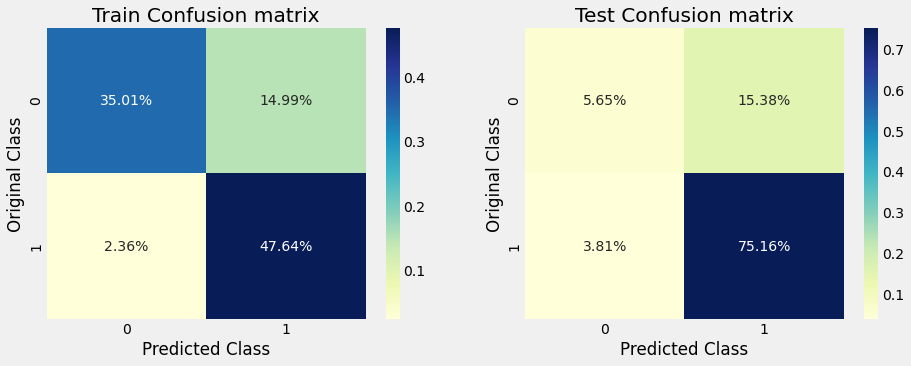

In [ ]:
clf = LogisticRegression(C=10, solver='newton-cg').fit(X_train_res, y_train_res)
performace_of_model(clf, y_train_res, X_train_res, y_test, X_test)

## Ridge

In [ ]:
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, \
                           scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.842374 using {'alpha': 1.0}
0.842343 (0.001309) with: {'alpha': 0.1}
0.842338 (0.001310) with: {'alpha': 0.2}
0.842342 (0.001298) with: {'alpha': 0.3}
0.842345 (0.001296) with: {'alpha': 0.4}
0.842346 (0.001296) with: {'alpha': 0.5}
0.842348 (0.001299) with: {'alpha': 0.6}
0.842350 (0.001297) with: {'alpha': 0.7}
0.842357 (0.001298) with: {'alpha': 0.8}
0.842364 (0.001293) with: {'alpha': 0.9}
0.842374 (0.001289) with: {'alpha': 1.0}


Matthews coef on Train data is  0.6688533101684337
Matthews coef on Test data is  0.29169019652136197
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.95      0.67      0.79     47248
     class 1       0.75      0.97      0.84     47248

    accuracy                           0.82     94496
   macro avg       0.85      0.82      0.82     94496
weighted avg       0.85      0.82      0.82     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.63      0.22      0.33      6197
     class 1       0.82      0.97      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.73      0.59      0.61     29469
weighted avg       0.78      0.81      0.77     29469



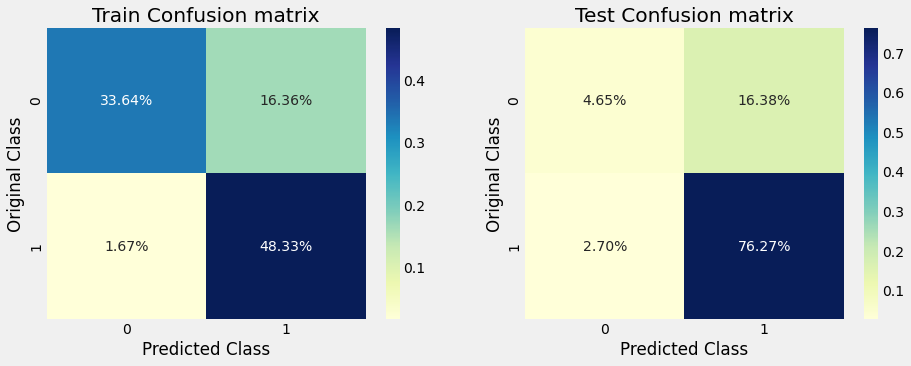

In [ ]:
clf = RidgeClassifier(alpha=1.0).fit(X_train_res, y_train_res)
performace_of_model(clf, y_train_res, X_train_res, y_test, X_test)

## Navie Bayes

Matthews coef on Train data is  0.385466977948791
Matthews coef on Test data is  0.09990166379132585
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.64      0.84      0.73     47248
     class 1       0.77      0.53      0.62     47248

    accuracy                           0.68     94496
   macro avg       0.70      0.68      0.68     94496
weighted avg       0.70      0.68      0.68     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.25      0.60      0.35      6197
     class 1       0.83      0.53      0.64     23272

    accuracy                           0.54     29469
   macro avg       0.54      0.56      0.50     29469
weighted avg       0.71      0.54      0.58     29469



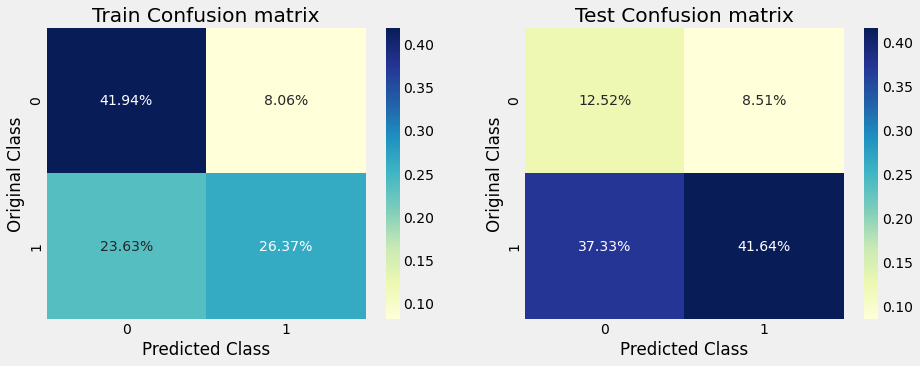

In [ ]:
GNB = GaussianNB().fit(X_train_res, y_train_res)
performace_of_model(GNB, y_train_res, X_train_res, y_test, X_test)

## SGD

F1 Score on Train data  0.8452375382484771
F1 Score on Test data  0.887132507035507
/n Matthews coef on Train data is  0.6734475388719373
Matthews coef on Test data is  0.30196085884504414
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.94      0.69      0.80     47248
     class 1       0.76      0.96      0.85     47248

    accuracy                           0.82     94496
   macro avg       0.85      0.82      0.82     94496
weighted avg       0.85      0.82      0.82     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.60      0.26      0.36      6197
     class 1       0.83      0.95      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.72      0.61      0.62     29469
weighted avg       0.78      0.81      0.78     29469



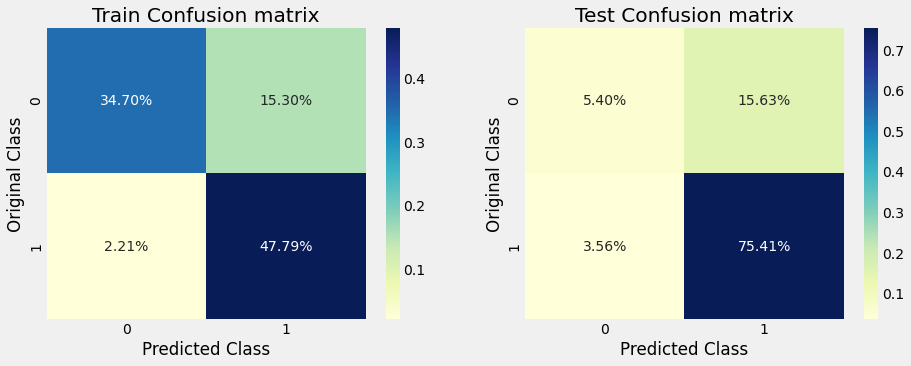

In [ ]:
SGD = SGDClassifier().fit(X_train_res, y_train_res)
performace_of_model(SGD, y_train_res, X_train_res, y_test, X_test)

In [ ]:
# https://www.knowledgehut.com/tutorials/machine-learning/hyperparameter-tuning-machine-learning
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge','perceptron']
penalty = ['l1', 'l2', 'elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 
eta0 = [1, 10, 100] 
param_distributions = dict(loss=loss, penalty=penalty, alpha=alpha, \
                           learning_rate=learning_rate, class_weight=class_weight, eta0=eta0) 

sgd = SGDClassifier(max_iter=20) 
random = RandomizedSearchCV(estimator=sgd, cv=3, param_distributions=param_distributions,\
                            scoring='f1', verbose=1, n_jobs=-1, n_iter=200)

In [ ]:
random_result = random.fit(X_train, y_train) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best Score:  0.8947289947662002
Best Params:  {'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'invscaling', 'eta0': 1, 'class_weight': {1: 0.6, 0: 0.4}, 'alpha': 0.01}


In [ ]:
random_result.best_estimator_

SGDClassifier(alpha=0.01, class_weight={0: 0.4, 1: 0.6}, eta0=1,
              learning_rate='invscaling', max_iter=20)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


F1 Score on Train data  0.7479841374752147
F1 Score on Test data  0.8881138392857144
/n Matthews coef on Train data is  0.42837828241396075
Matthews coef on Test data is  0.3056202003138024
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.90      0.40      0.55     47248
     class 1       0.61      0.96      0.75     47248

    accuracy                           0.68     94496
   macro avg       0.76      0.68      0.65     94496
weighted avg       0.76      0.68      0.65     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.61      0.25      0.36      6197
     class 1       0.83      0.96      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.72      0.61      0.62     29469
weighted avg       0.78      0.81      0.78     29469



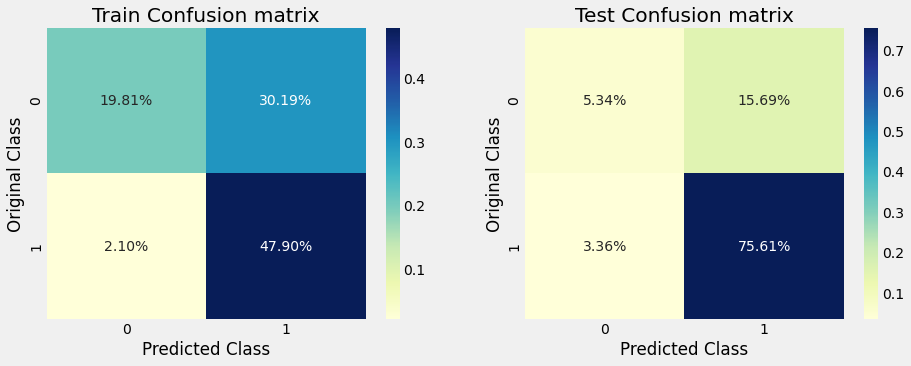

In [ ]:
SGD = SGDClassifier(class_weight={1: 0.6, 0: 0.4}, eta0=1, loss='hinge', alpha=0.01,
              learning_rate='invscaling', max_iter=30, penalty='l2').fit(X_train_res, y_train_res)
performace_of_model(SGD, y_train_res, X_train_res, y_test, X_test)

## Decision Tree

Matthews coef on Train data is  1.0
Matthews coef on Test data is  0.13091032722452484
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     47248
     class 1       1.00      1.00      1.00     47248

    accuracy                           1.00     94496
   macro avg       1.00      1.00      1.00     94496
weighted avg       1.00      1.00      1.00     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.31      0.34      0.32      6197
     class 1       0.82      0.80      0.81     23272

    accuracy                           0.70     29469
   macro avg       0.56      0.57      0.57     29469
weighted avg       0.71      0.70      0.71     29469



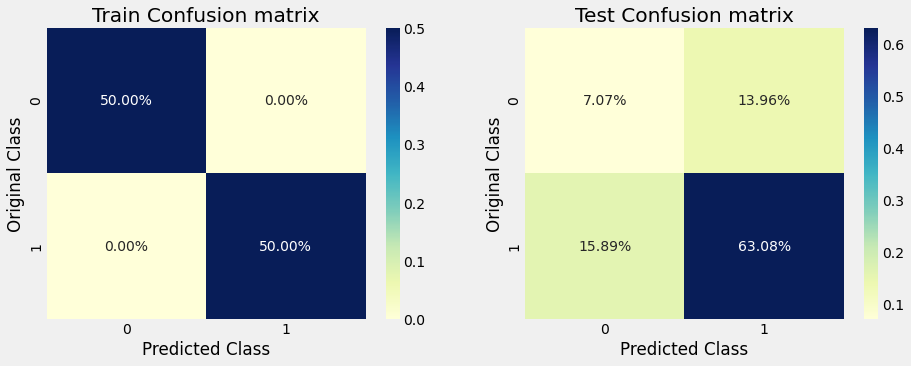

In [ ]:
dtclf = DecisionTreeClassifier().fit(X_train_res, y_train_res)
performace_of_model(dtclf, y_train_res, X_train_res, y_test, X_test)

Matthews coef on Train data is  1.0
Matthews coef on Test data is  0.31059693736209704
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     47248
     class 1       1.00      1.00      1.00     47248

    accuracy                           1.00     94496
   macro avg       1.00      1.00      1.00     94496
weighted avg       1.00      1.00      1.00     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.62      0.26      0.37      6197
     class 1       0.83      0.96      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.72      0.61      0.63     29469
weighted avg       0.78      0.81      0.78     29469



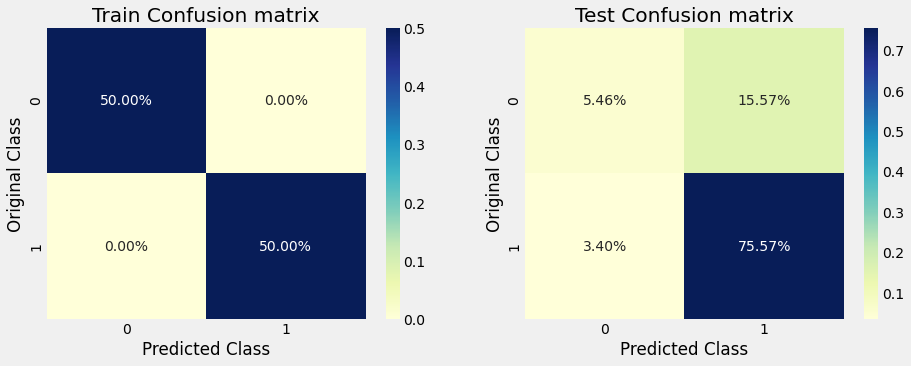

In [ ]:
rfcl = RandomForestClassifier().fit(X_train_res, y_train_res)
performace_of_model(rfcl, y_train_res, X_train_res, y_test, X_test)

* Hyperparameter tunning using Optuna

In [ ]:
def objective(trial):
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 200)
    n_estimators = trial.suggest_int("n_estimators", 10,2000)
    max_features = trial.suggest_categorical("max_features", ["auto", "sqrt"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split",2,20)
    bootstrap = trial.suggest_categorical("bootstrap",[True, False])

    rf = RandomForestClassifier(criterion =criterion,
            max_depth=max_depth, 
            n_estimators=n_estimators,
            max_features = max_features,
            min_samples_leaf = min_samples_leaf,
            min_samples_split = min_samples_split,
            bootstrap = bootstrap,
            n_jobs = -1
        )

    score = cross_val_score(rf, X_train_res, y_train_res, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

In [ ]:
trial = study.best_trial
print('F1 Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
# result of above hypertunnung
# criterion='gini', max_depth=46, n_estimators=778, max_features='sqrt', min_samples_leaf=3, min_samples_split=10, bootstrap = False

Matthews coef on Train data is  0.9827499145934707
Matthews coef on Test data is  0.3188894195113862
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99     47248
     class 1       0.99      1.00      0.99     47248

    accuracy                           0.99     94496
   macro avg       0.99      0.99      0.99     94496
weighted avg       0.99      0.99      0.99     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.65      0.25      0.36      6197
     class 1       0.83      0.96      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.74      0.61      0.63     29469
weighted avg       0.79      0.81      0.78     29469



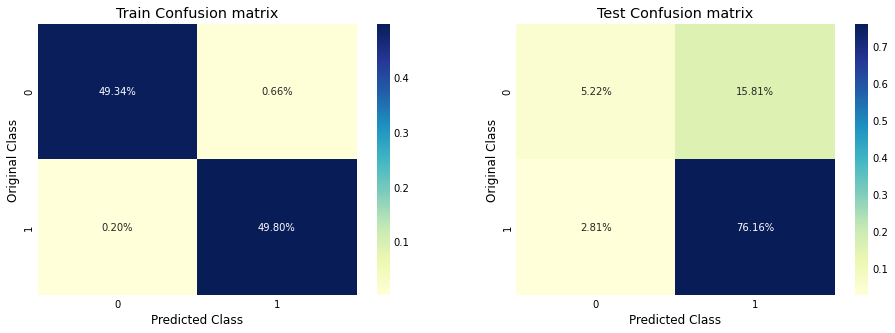

In [ ]:
rfcl = RandomForestClassifier(criterion='gini', max_depth=46, n_estimators=778, 
                              max_features='sqrt', min_samples_leaf=3, min_samples_split=10, \
                              bootstrap = False, n_jobs=-1).fit(X_train_res, y_train_res)
performace_of_model(rfcl, y_train_res, X_train_res, y_test, X_test)

Matthews coef on Train data is  0.793276513339809
Matthews coef on Test data is  0.34096106530858916
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.98      0.80      0.88     47248
     class 1       0.83      0.98      0.90     47248

    accuracy                           0.89     94496
   macro avg       0.90      0.89      0.89     94496
weighted avg       0.90      0.89      0.89     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.73      0.23      0.35      6197
     class 1       0.83      0.98      0.90     23272

    accuracy                           0.82     29469
   macro avg       0.78      0.60      0.62     29469
weighted avg       0.81      0.82      0.78     29469



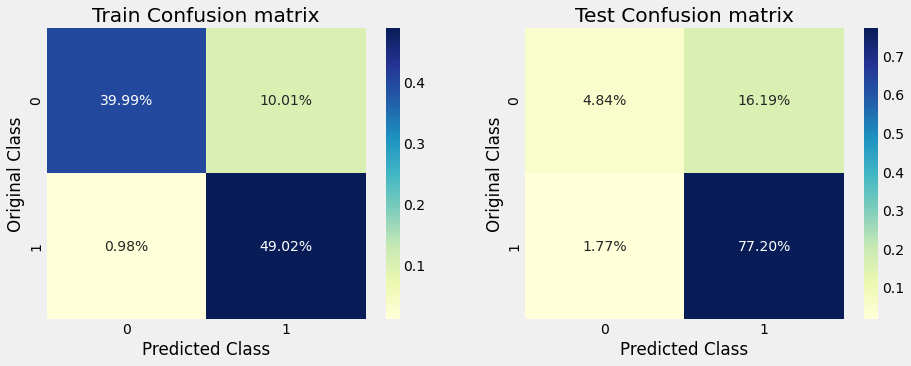

In [ ]:
lgbclf = lgb.LGBMClassifier().fit(X_train_res, y_train_res)
performace_of_model(lgbclf, y_train_res, X_train_res, y_test, X_test)

Learning rate set to 0.071851
0:	learn: 0.6730382	total: 89.6ms	remaining: 1m 29s
1:	learn: 0.6518987	total: 122ms	remaining: 1m
2:	learn: 0.6399046	total: 150ms	remaining: 49.9s
3:	learn: 0.6233007	total: 186ms	remaining: 46.3s
4:	learn: 0.6146244	total: 211ms	remaining: 42.1s
5:	learn: 0.5902197	total: 245ms	remaining: 40.6s
6:	learn: 0.5779078	total: 276ms	remaining: 39.1s
7:	learn: 0.5684056	total: 309ms	remaining: 38.3s
8:	learn: 0.5576798	total: 344ms	remaining: 37.8s
9:	learn: 0.5495242	total: 375ms	remaining: 37.1s
10:	learn: 0.5407878	total: 412ms	remaining: 37s
11:	learn: 0.5347957	total: 448ms	remaining: 36.9s
12:	learn: 0.5273032	total: 478ms	remaining: 36.3s
13:	learn: 0.5223023	total: 506ms	remaining: 35.7s
14:	learn: 0.5157517	total: 537ms	remaining: 35.3s
15:	learn: 0.5034835	total: 572ms	remaining: 35.2s
16:	learn: 0.4990926	total: 603ms	remaining: 34.8s
17:	learn: 0.4941332	total: 635ms	remaining: 34.6s
18:	learn: 0.4907923	total: 663ms	remaining: 34.2s
19:	learn: 0.4

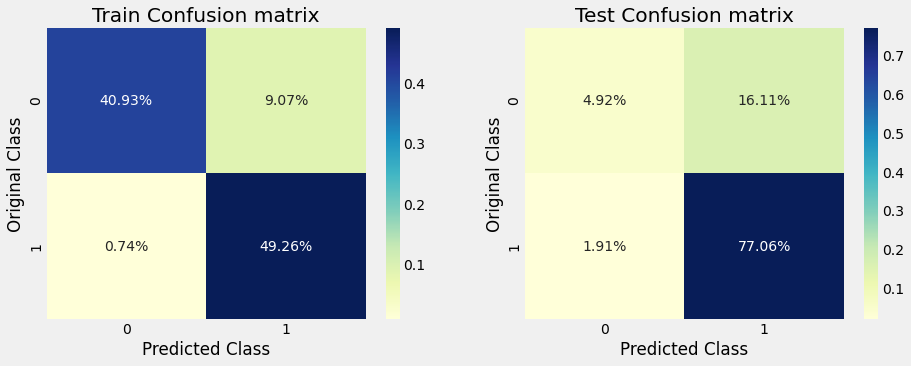

In [ ]:
catclf = CatBoostClassifier().fit(X_train_res, y_train_res)
performace_of_model(catclf, y_train_res, X_train_res, y_test, X_test)

## XGBoost

Matthews coef on Train data is  0.7246608275272917
Matthews coef on Test data is  0.29770988083851246
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.94      0.76      0.84     47248
     class 1       0.80      0.95      0.87     47248

    accuracy                           0.86     94496
   macro avg       0.87      0.86      0.85     94496
weighted avg       0.87      0.86      0.85     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.59      0.26      0.36      6197
     class 1       0.83      0.95      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.71      0.61      0.62     29469
weighted avg       0.78      0.81      0.78     29469



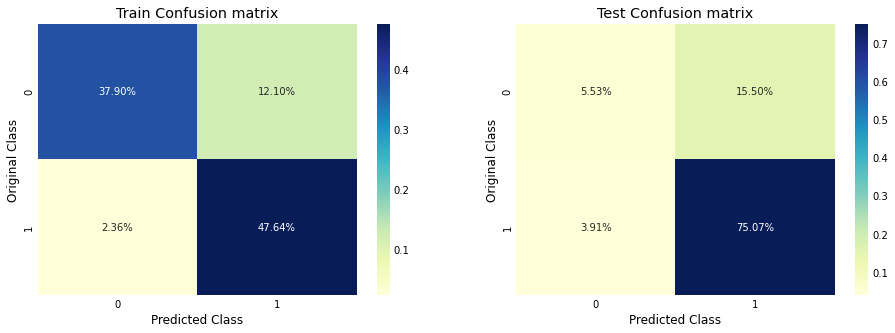

In [ ]:
xgb_cl = xgb.XGBClassifier().fit(X_train_res, y_train_res)
performace_of_model(xgb_cl, y_train_res, X_train_res, y_test, X_test)

* Hyperparameter tunning using Optuna

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 100)
    subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)

    xgb_cl = xgb.XGBClassifier(max_depth = max_depth,
            subsample = subsample, 
            n_estimators = n_estimators,
            colsample_bytree = colsample_bytree,
            learning_rate = learning_rate,
            n_jobs = -1
        )

    score = cross_val_score(xgb_cl, X_train_res, y_train_res, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[I 2022-01-27 17:23:38,493] A new study created in memory with name: no-name-0cd0df6e-3a58-4c2a-8673-b469e3e3d69a


[17:23:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-01-27 17:40:25,950] Trial 0 finished with value: 0.8491415585459771 and parameters: {'max_depth': 60, 'subsample': 0.8067594715828824, 'colsample_bytree': 0.36794353445249794, 'learning_rate': 0.13880218763033986, 'n_estimators': 744}. Best is trial 0 with value: 0.8491415585459771.


[17:23:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

[17:23:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:56:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

[17:56:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
# result of above hypertunning
# 'max_depth': 39, 'subsample': 0.7574605895648927, 'colsample_bytree': 0.5338268978409916, 'learning_rate': 0.29610657876769103, 'n_estimators': 974}

Matthews coef on Train data is  1.0
Matthews coef on Test data is  0.2921909899882472
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     47248
     class 1       1.00      1.00      1.00     47248

    accuracy                           1.00     94496
   macro avg       1.00      1.00      1.00     94496
weighted avg       1.00      1.00      1.00     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.58      0.26      0.36      6197
     class 1       0.83      0.95      0.88     23272

    accuracy                           0.80     29469
   macro avg       0.70      0.60      0.62     29469
weighted avg       0.78      0.80      0.77     29469



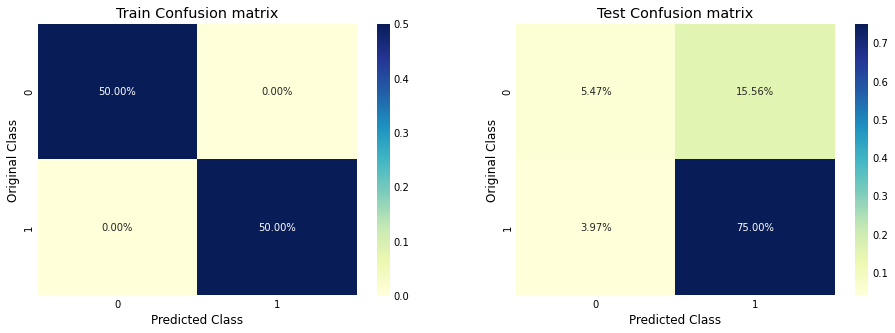

In [ ]:
xgb_cl = xgb.XGBClassifier(max_depth= 20, subsample= 0.7574605895648927, \
                           colsample_bytree= 0.5338268978409916, learning_rate= 0.29610657876769103, \
                           n_estimators= 974).fit(X_train_res, y_train_res)
performace_of_model(xgb_cl, y_train_res, X_train_res, y_test, X_test)

## Stacking

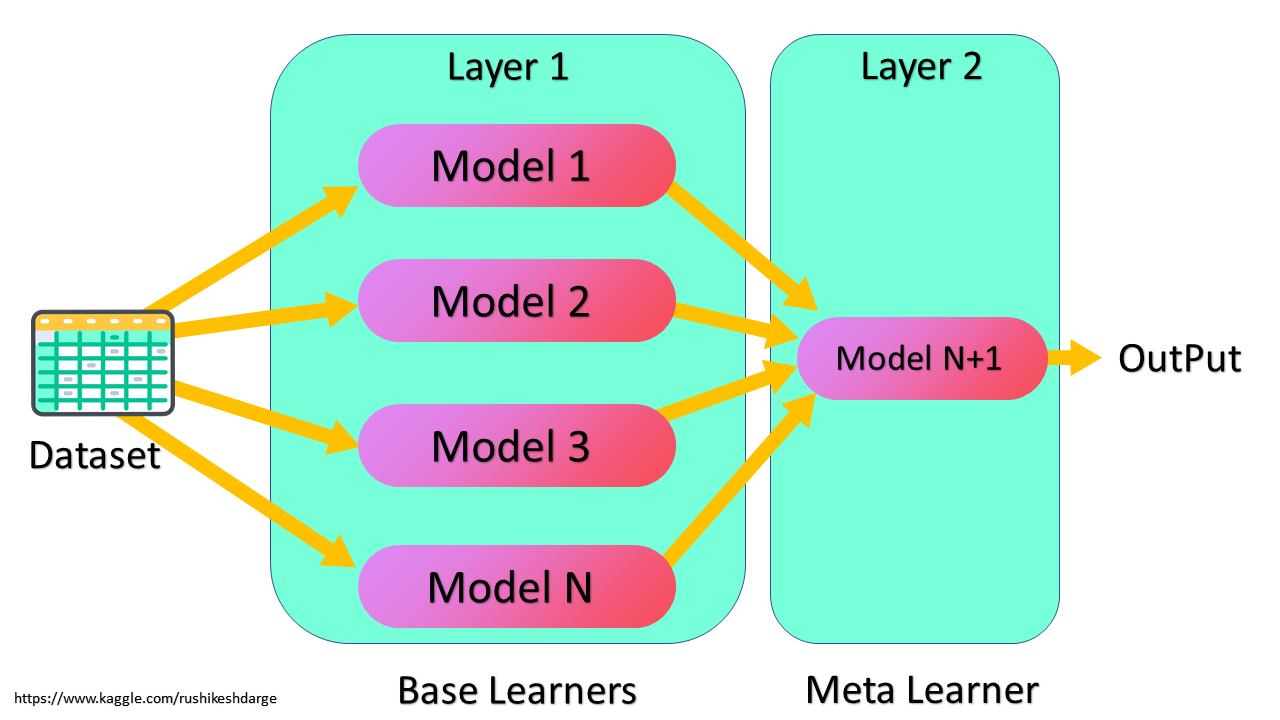

In [ ]:
# check model performance of stacking
# https://www.kaggle.com/rushikeshdarge/competition-winning-models-stacking
def get_stacking():
    """
    Return 
    ----------------
    Stack model  
    """
    level0 = list()  # First layer
    level0.append(('lr',LogisticRegression(C=10, solver='newton-cg')))
    level0.append(('Ridge',RidgeClassifier(alpha=1.0)))
    level0.append(('GB',GaussianNB()))

    level1 = LogisticRegression(solver='liblinear') #Second layer
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    return model

In [ ]:
def evaluate_model(model,X,y):
    """
    Return
    -----------
    Return accracy score that perform base on Cross Validation
    """
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(np.mean(scores))
    return scores

In [ ]:
# run stacking modelwith cross validation
scores = evaluate_model(get_stacking(), X_train_res, y_train_res)

0.8245692939383678


In [ ]:
scores

array([0.82538943, 0.82380207, 0.82507196, 0.82401371])

In [ ]:
# build stacking model
level0 = list()  # First layer
level0.append(('lr',LogisticRegression(C=10, solver='newton-cg')))
level0.append(('Ridge',RidgeClassifier(alpha=1.0)))
level0.append(('GB',GaussianNB()))

level1 = LogisticRegression(solver='liblinear') #Second layer
# make model using first and second layer
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
model.fit(X_train_res, y_train_res)

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=10, solver='newton-cg')),
                               ('Ridge', RidgeClassifier()),
                               ('GB', GaussianNB())],
                   final_estimator=LogisticRegression(solver='liblinear'))

F1 Score on Train data  0.8412311822801803
F1 Score on Test data  0.8785084773361014

 Matthews coef on Train data is  0.6639729904673835
Matthews coef on Test data is  0.29457980604195405
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.91      0.72      0.80     47248
     class 1       0.77      0.93      0.84     47248

    accuracy                           0.82     94496
   macro avg       0.84      0.82      0.82     94496
weighted avg       0.84      0.82      0.82     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.53      0.31      0.39      6197
     class 1       0.83      0.93      0.88     23272

    accuracy                           0.80     29469
   macro avg       0.68      0.62      0.63     29469
weighted avg       0.77      0.80      0.78     29469



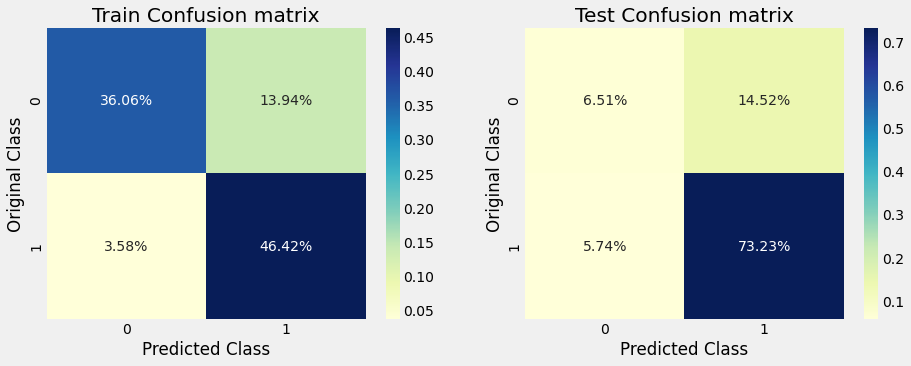

In [ ]:
performace_of_model(model, y_train_res, X_train_res, y_test, X_test)

## Neural Network

In [ ]:
# in neural network model.predict give little different output
# to check performance of Neural network
def performace_of_model_nn(model, history, y_train, X_train, y_test,X_test):
    # to check the performance of neural network model
    # predict using model
    y_train_pred = np.where(model.predict(X_train) > 0.5, 1,0)
    y_test_pred = np.where(model.predict(X_test) > 0.5, 1,0)

    # printing matthew coef for train and test
    print('Matthews coef on Train data is ',matthews_corrcoef(y_train, y_train_pred))
    print('Matthews coef on Test data is ',matthews_corrcoef(y_test,y_test_pred))

    # printing classification report
    target_names = ['class 0', 'class 1']
    print('Classification report for train data is : \n')
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    print('Classification report for test data is : \n')
    print(classification_report(y_test,y_test_pred, target_names=target_names))

    # creating confusion matrix
    cf_train = confusion_matrix(y_train,y_train_pred)
    cf_test = confusion_matrix(y_test,y_test_pred)
    cf_ideal = confusion_matrix(y_test,y_test)

    # heatmap of confusion matrix on train data
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(cf_train/np.sum(cf_train), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Train Confusion matrix")

    # heatmap of confusion matrix on test data
    plt.subplot(1,2,2)
    sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Test Confusion matrix")
    plt.show()

    # plotting accuracy
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plotting loss 
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(52, input_dim=52, activation='relu'))
model.add(Dense(24, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# fit the keras model on the dataset
history = model.fit(X_train_res, y_train_res, epochs=350, batch_size=1000, \
                    validation_data=(X_test,y_test), callbacks=[early_stop])

Epoch 1/350
95/95 [==============================] - 3s 11ms/step - loss: 3.0303 - accuracy: 0.4761 - val_loss: 3.1302 - val_accuracy: 0.2936
Epoch 2/350
95/95 [==============================] - 1s 9ms/step - loss: 2.9590 - accuracy: 0.4609 - val_loss: 2.9998 - val_accuracy: 0.3804
Epoch 3/350
95/95 [==============================] - 1s 8ms/step - loss: 2.9309 - accuracy: 0.4599 - val_loss: 2.9438 - val_accuracy: 0.4260
Epoch 4/350
95/95 [==============================] - 1s 6ms/step - loss: 2.9128 - accuracy: 0.4632 - val_loss: 2.9176 - val_accuracy: 0.4399
Epoch 5/350
95/95 [==============================] - 0s 5ms/step - loss: 2.8965 - accuracy: 0.4665 - val_loss: 2.8984 - val_accuracy: 0.4470
Epoch 6/350
95/95 [==============================] - 1s 6ms/step - loss: 2.8807 - accuracy: 0.4698 - val_loss: 2.8824 - val_accuracy: 0.4511
Epoch 7/350
95/95 [==============================] - 1s 6ms/step - loss: 2.8651 - accuracy: 0.4721 - val_loss: 2.8652 - val_accuracy: 0.4580
Epoch 8/350


Matthews coef on Train data is  0.6534972667256453
Matthews coef on Test data is  0.2965391489698247
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.90      0.72      0.80     47248
     class 1       0.77      0.92      0.84     47248

    accuracy                           0.82     94496
   macro avg       0.83      0.82      0.82     94496
weighted avg       0.83      0.82      0.82     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.52      0.32      0.40      6197
     class 1       0.84      0.92      0.88     23272

    accuracy                           0.80     29469
   macro avg       0.68      0.62      0.64     29469
weighted avg       0.77      0.80      0.78     29469



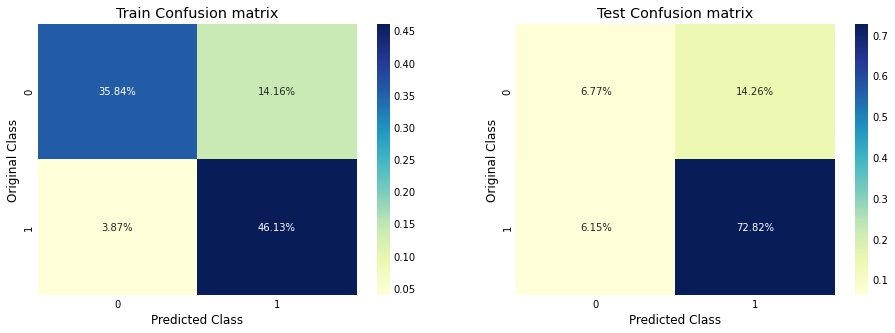

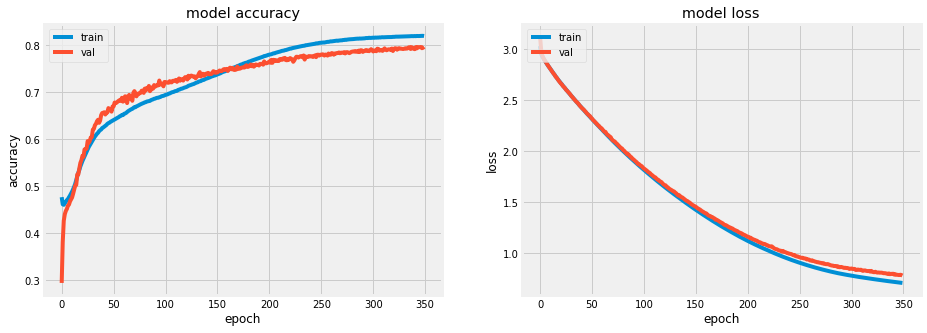

In [ ]:
performace_of_model_nn(model, history, y_train_res, X_train_res, y_test, X_test)

# Overview of Models

In [ ]:
score_table = {'Model': ['LR', 'Ridge', 'Navie Bayes', 'SGD', 'DT', 'RF', 'LGB', 'catB', 'XGB', 'Stack', 'NN'],
        'Matthew Train': [0.67, 0.66, 0.38, 0.50, 1.0, 0.98, 0.79, 0.81, 1.0, 0.66, 0.65],
        'Matthew Test': [0.30, 0.29, 0.09, 0.25, 0.13, 0.31, 0.34, 0.33, 0.29, 0.29, 0.29],
        'FP% of Test': [15.4, 16.38, 8.51, 13.31, 14, 15.8, 16.19, 16.11, 15.5, 14.5, 14.2],
        'FN% of Test': [3.81, 2.70, 37.33, 10.06, 15.89, 2.81, 1.77, 2, 4, 5.7, 6.15]} 

score = pd.DataFrame.from_dict(score_table)
score

,Model,Matthew Train,Matthew Test,FP% of Test,FN% of Test
0,LR,0.67,0.30,15.40,3.81
1,Ridge,0.66,0.29,16.38,2.70
2,Navie Bayes,0.38,0.09,8.51,37.33
3,SGD,0.50,0.25,13.31,10.06
4,DT,1.00,0.13,14.00,15.89
5,RF,0.98,0.31,15.80,2.81
6,LGB,0.79,0.34,16.19,1.77
7,catB,0.81,0.33,16.11,2.00
8,XGB,1.00,0.29,15.50,4.00
9,Stack,0.66,0.29,14.50,5.70


* All models are easily overfit 

# Good Fit models

## Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


F1 Score on Train data  0.7205270620676689
F1 Score on Test data  0.8929155259685265
/n Matthews coef on Train data is  0.3438017638132945
Matthews coef on Test data is  0.3169304368609935
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.91      0.27      0.42     47248
     class 1       0.57      0.97      0.72     47248

    accuracy                           0.62     94496
   macro avg       0.74      0.62      0.57     94496
weighted avg       0.74      0.62      0.57     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.69      0.22      0.33      6197
     class 1       0.82      0.97      0.89     23272

    accuracy                           0.82     29469
   macro avg       0.76      0.60      0.61     29469
weighted avg       0.80      0.82      0.78     29469



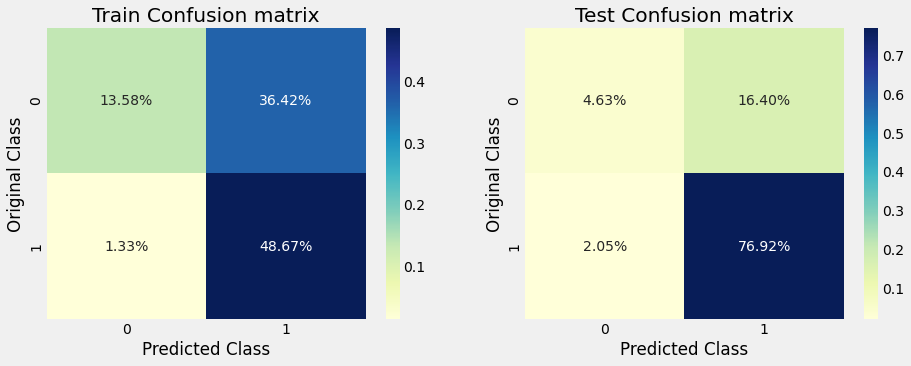

In [ ]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1000, random_state=42, \
                         solver='liblinear', max_iter=5, n_jobs=-1).fit(X_train_res[:60000], y_train_res[:60000])
performace_of_model(clf, y_train_res, X_train_res, y_test, X_test)

* After trying with multiple paramerters we still overfit a bit
* When we reduce the number of training data then model fit well

## RandomForest

F1 Score on Train data  0.7221223938920757
F1 Score on Test data  0.8931950796404352
/n Matthews coef on Train data is  0.34945114083545575
Matthews coef on Test data is  0.32106365253572583
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.91      0.28      0.42     47248
     class 1       0.57      0.97      0.72     47248

    accuracy                           0.63     94496
   macro avg       0.74      0.63      0.57     94496
weighted avg       0.74      0.63      0.57     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.69      0.23      0.34      6197
     class 1       0.83      0.97      0.89     23272

    accuracy                           0.82     29469
   macro avg       0.76      0.60      0.62     29469
weighted avg       0.80      0.82      0.78     29469



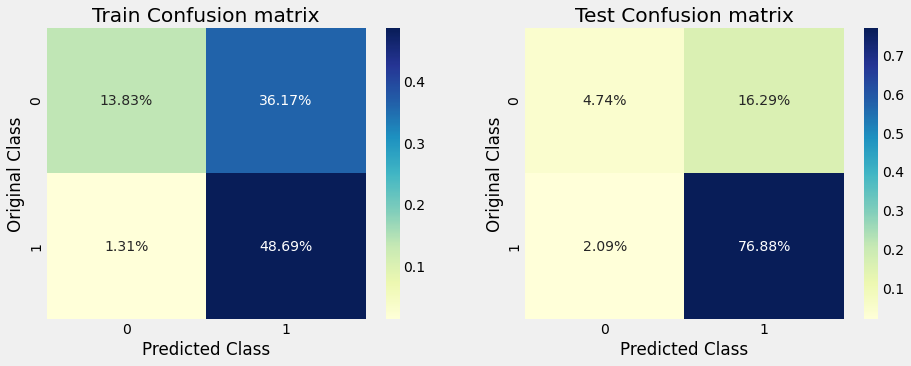

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=3, \
                               min_samples_split=5, min_samples_leaf=2, \
                               max_features=10, max_leaf_nodes=20, \
                               bootstrap=True, oob_score=True, n_jobs=-1, random_state=42, \
                               max_samples=0.3).fit(X_train_res[:70000], y_train_res[:70000])
performace_of_model(rf_clf, y_train_res, X_train_res, y_test, X_test)

* Reducing the depth, n_estimators, max sample and also by reduce number points in training we get well fit model

In [ ]:
# save
# joblib.dump(rf_clf, "random_forest_model.joblib")

['random_forest_model.joblib']

In [ ]:
# load model
rf = joblib.load("random_forest_model.joblib")
rf.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
rf.score(X_test,y_test)

0.8161457803115137

## SVM

F1 Score on Train data  0.7214432663396108
F1 Score on Test data  0.8896946640511998
/n Matthews coef on Train data is  0.34541606028667843
Matthews coef on Test data is  0.3038126804497824
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.89      0.29      0.44     47248
     class 1       0.58      0.96      0.72     47248

    accuracy                           0.63     94496
   macro avg       0.73      0.63      0.58     94496
weighted avg       0.73      0.63      0.58     94496

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.64      0.23      0.34      6197
     class 1       0.83      0.96      0.89     23272

    accuracy                           0.81     29469
   macro avg       0.73      0.60      0.62     29469
weighted avg       0.79      0.81      0.77     29469



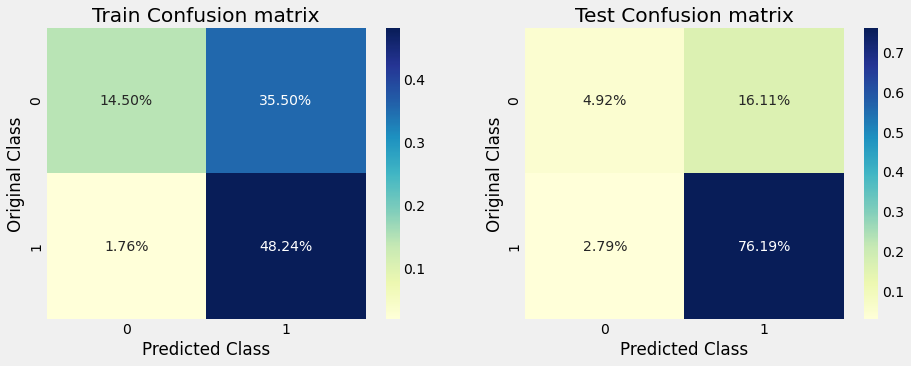

In [ ]:
svm_clf = SVC(kernel = 'linear').fit(X_train_res[:10000], y_train_res[:10000])
performace_of_model(svm_clf, y_train_res, X_train_res, y_test, X_test)

* We found linear kernel give better result.

In [ ]:
good_fit_model_table = {'Model': ['LR', 'RF', 'SVM'],
        'Matthew Train': [0.35, 0.34, 0.34],
        'Matthew Test': [0.31 ,0.32 ,0.30],
        'FP% of Test': [16.40, 16.30, 16.11],
        'FN% of Test': [2.05, 2.09, 2.79]} 

good_fit_model = pd.DataFrame.from_dict(good_fit_model_table)
good_fit_model

,Model,Matthew Train,Matthew Test,FP% of Test,FN% of Test
0,LR,0.35,0.31,16.40,2.05
1,RF,0.34,0.32,16.30,2.09
2,SVM,0.34,0.30,16.11,2.79


* Random forest give better result we use Random forest to deploy model